In [14]:
import os
print(os.getcwd())
if os.getcwd().endswith("mri_data"):
    os.chdir("..")
    os.chdir("..")
print(os.getcwd())
from src.modelling import DeepModel_Trainer
from src.augmentation import Transformer,None_Transform
from src.data_modules import DataModule,ImagesDataset
from torch import nn
import pandas as pd
import torch
from torchvision import transforms,models
import nibabel as nib
import numpy as np
from src.evaluation import Evaluation
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

/mnt/batch/tasks/shared/LS_root/mounts/clusters/ksathmed2/code/Users/pro5d-classification-prolactinoma
/mnt/batch/tasks/shared/LS_root/mounts/clusters/ksathmed2/code/Users/pro5d-classification-prolactinoma


In [15]:
%env "WANDB_NOTEBOOK_NAME" "baseline"
%env WANDB_SILENT=True

base_transformer = Transformer(
    None_Transform(), "select_roi"
)

env: "WANDB_NOTEBOOK_NAME"="baseline"
env: WANDB_SILENT=True


In [16]:
# Modify the first convolution layer
# Original first conv layer: in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False
def resnet18():
    model = models.resnet18(pretrained=True)
    model.conv1 = nn.Conv2d(in_channels=6, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1)
    return model

In [ ]:
resnet18_base = DeepModel_Trainer(DataModule(base_transformer), resnet18)
resnet18_base.train_model("Baseline Resnet", "Resnet 18", num_epochs=2, test_model=False,batchsize_train_data=16,use_mri_images=True,use_tabular_data=False,num_workers=6,
                     save_model=False,
                     cross_validation=True,lr=0.0001,evaluate_test_set=False,project_name="MRI-Modell")

In [ ]:
resnet18_base = DeepModel_Trainer(DataModule(base_transformer), resnet18)
resnet18_base.train_model("Weighted", "Resnet 18", num_epochs=6, test_model=False,batchsize_train_data=16,use_mri_images=True,use_tabular_data=False,num_workers=6,
                     save_model=False,
                     cross_validation=True,lr=0.0001,evaluate_test_set=False,project_name="MRI-Modell",weight_loss=True)

In [5]:
Evaluation().visualize_slices(fold=3,index=[4,10,55,61],preprocess_slices=Transformer.select_roi)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/ksathmed1/code/Users/pro5d-classification-prolactinoma/src/augmentation.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  slice = torch.tensor(slice).unsqueeze(0)  # Add a channel dimension


interactive(children=(IntSlider(value=1, description='mri', max=3), IntSlider(value=7, description='slice_numb…

In [ ]:
augmentation_transformer = Transformer(
    transforms.Compose([transforms.RandomRotation(5),transforms.RandomHorizontalFlip(0.2)]), "select_roi"
)
resnet18_base = DeepModel_Trainer(DataModule(augmentation_transformer), resnet18)
resnet18_base.train_model("Augmented_weighted", "Resnet 18", num_epochs=8, test_model=False,batchsize_train_data=16,use_mri_images=True,use_tabular_data=False,num_workers=6,
                     save_model=False,
                     cross_validation=True,lr=0.0001,evaluate_test_set=False,project_name="MRI-Modell",weight_loss=True)

In [ ]:
augmentation_transformer = Transformer(
    transforms.Compose([transforms.RandomRotation(5),transforms.RandomHorizontalFlip(0.2)]), "select_roi"
)
resnet18_base = DeepModel_Trainer(DataModule(augmentation_transformer), resnet18)
resnet18_base.train_model("Augmented_weighted_batchsize_8", "Resnet 18", num_epochs=8, test_model=False,batchsize_train_data=8,use_mri_images=True,use_tabular_data=False,num_workers=6,
                     save_model=False,
                     cross_validation=True,lr=0.0001,evaluate_test_set=False,project_name="MRI-Modell",weight_loss=True)

In [ ]:
augmentation_transformer = Transformer(
    transforms.Compose([transforms.RandomRotation(5),transforms.RandomHorizontalFlip(0.2),transforms.RandomVerticalFlip(0.2),transforms.ColorJitter(0.02,0.02,0.02,0.02)]), "select_roi"
)
resnet18_base = DeepModel_Trainer(DataModule(augmentation_transformer), resnet18)
resnet18_base.train_model("Augmented_diverse_weighted", "Resnet 18", num_epochs=8, test_model=False,batchsize_train_data=16,use_mri_images=True,use_tabular_data=False,num_workers=6,
                     save_model=False,
                     cross_validation=True,lr=0.0001,evaluate_test_set=False,project_name="MRI-Modell",weight_loss=True)

In [ ]:
augmentation_transformer = Transformer(
    transforms.Compose([transforms.RandomRotation(5),transforms.RandomHorizontalFlip(0.2)]), "select_roi"
)
resnet18_base = DeepModel_Trainer(DataModule(augmentation_transformer), resnet18)
resnet18_base.train_model("Augmented_weighted_decreased_by_1.5", "Resnet 18", num_epochs=8, test_model=False,batchsize_train_data=16,use_mri_images=True,use_tabular_data=False,num_workers=6,
                     save_model=False,
                     cross_validation=True,lr=0.0001,evaluate_test_set=False,project_name="MRI-Modell",weight_loss=True,weight_loss_decrease=1.5)

In [14]:
# Modify the first convolution layer
# Original first conv layer: in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False
def resnet18_freezed():
    model = models.resnet18(pretrained=True)
    model_freeze(model,8)
    model.conv1 = nn.Conv2d(in_channels=6, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1)

    return model

def model_freeze(model,n_block):
    backbone = list(model.children())
    print(f"The Backbone has {len(backbone)} blocks")
    ct = 0
    for child in backbone:
        ct += 1
        if ct < n_block:
            for param in child.parameters():
                param.requires_grad = False
        else:
            print("No freeze")
            print(child)

In [ ]:
augmentation_transformer = Transformer(
    transforms.Compose([transforms.RandomRotation(5),transforms.RandomHorizontalFlip(0.2)]), "select_roi"
)
resnet18_base = DeepModel_Trainer(DataModule(augmentation_transformer), resnet18_freezed)
resnet18_base.train_model("Augmented_weighted_freezed", "Resnet 18", num_epochs=8, test_model=False,batchsize_train_data=16,use_mri_images=True,use_tabular_data=False,num_workers=6,
                     save_model=False,
                     cross_validation=True,lr=0.0001,evaluate_test_set=False,project_name="MRI-Modell",weight_loss=True)

In [ ]:
small_imsize = Transformer(
    None_Transform(), "select_roi_small_imsize"
)
def resnet18_3channel():
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1)
    return model

In [ ]:
resnet18_base = DeepModel_Trainer(DataModule(small_imsize), resnet18_3channel)
resnet18_base.train_model("Select only 3 channels", "Resnet 18", num_epochs=7, test_model=False,batchsize_train_data=16,use_mri_images=True,use_tabular_data=False,num_workers=6,
                     save_model=False,
                     cross_validation=True,lr=0.0001,evaluate_test_set=False,project_name="MRI-Modell")

In [ ]:
resnet18_base = DeepModel_Trainer(DataModule(small_imsize), resnet18_3channel)
resnet18_base.train_model("Select only 3 channels weighted", "Resnet 18", num_epochs=12, test_model=False,batchsize_train_data=16,use_mri_images=True,use_tabular_data=False,num_workers=6,
                     save_model=False,
                     cross_validation=True,lr=0.0001,evaluate_test_set=False,project_name="MRI-Modell",weight_loss=True)

In [17]:
small_imsize_resnet_preproc = Transformer(
    None_Transform(), "select_roi_small_im_resnet"
)
def resnet18_3channel():
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1)
    return model

resnet18_base = DeepModel_Trainer(DataModule(small_imsize_resnet_preproc), resnet18_3channel)
resnet18_base.train_model("Select only 3 channels weighted norm resnet", "Resnet 18", num_epochs=12, test_model=False,batchsize_train_data=16,use_mri_images=True,use_tabular_data=False,num_workers=6,
                     save_model=False,
                     cross_validation=True,lr=0.0001,evaluate_test_set=False,project_name="MRI-Modell",weight_loss=True)


Fold-Iteration:   0%|          | 0/5 [00:00<?, ?fold/s]/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/mnt/batch/tasks/shared/LS_root/mounts/clusters/ksathmed2/code/Users/pro5d-classification-prolactinoma/src/modelling.py:203: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.t

### Threshhold for best model


In [4]:
def calc_metrics(y_true,y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    # Extract values from the confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    return sensitivity,specificity

In [5]:
thresh_results = []
for fold_num in range(5):
    results = pd.read_csv(f"./modelling/mri_data/results_augmented_weighted/fold-{fold_num}.csv")
    thresh_result_fold = []
    for threshhold in np.linspace(0,1,101):
        y_pred = (results["prediction"] > threshhold) 
        y_true = results["Ground_Truth"]
        thresh_result_fold.append(calc_metrics(y_true,y_pred))
    thresh_results.append(thresh_result_fold)

In [6]:
best_threshold = np.array(thresh_results).mean(axis=(0,2)).argmax()/100

In [7]:
np.array(thresh_results).mean(axis=(0))[11]

array([0.62416667, 0.62275034])

In [8]:
np.array(thresh_results).var(axis=(0))[11]

array([0.02071111, 0.00677064])

## Test on Testset, with full train_data

In [ ]:
augmentation_transformer = Transformer(
    transforms.Compose([transforms.RandomRotation(5),transforms.RandomHorizontalFlip(0.2)]), "select_roi"
)
resnet18_base = DeepModel_Trainer(DataModule(augmentation_transformer), resnet18)
resnet18_base.train_model("Augmented_weighted_Test", "Resnet 18", num_epochs=8, test_model=False,batchsize_train_data=16,use_mri_images=True,use_tabular_data=False,num_workers=6,
                     save_model=True,
                     cross_validation=True,lr=0.0001,evaluate_test_set=True,project_name="MRI-Modell",weight_loss=True)

In [9]:
results = pd.read_csv(f"./modelling/mri_data/results_augmented_weighted/test_results.csv")
y_pred = (results["prediction"] > best_threshold) 
y_true = results["Ground_Truth"]
calc_metrics(y_true,y_pred)

(0.6046511627906976, 0.5918367346938775)

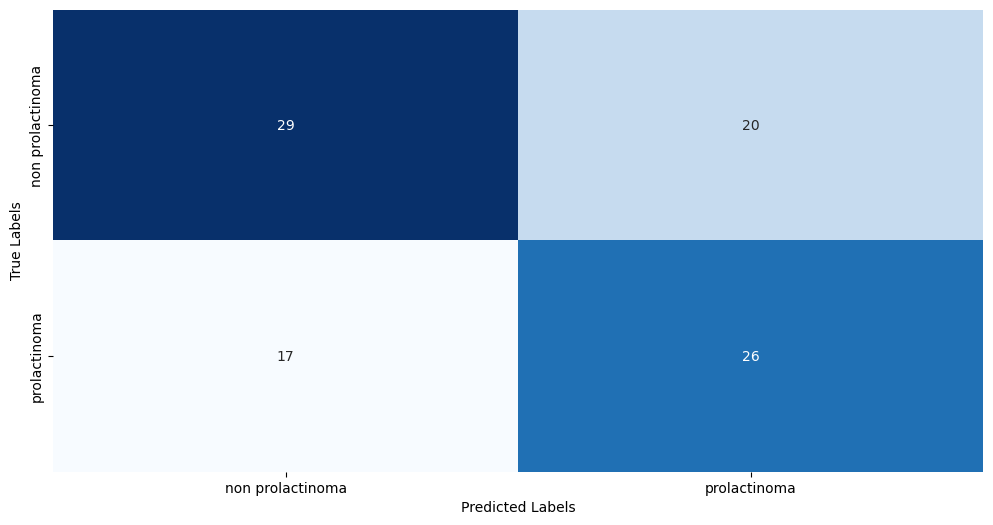

In [10]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            cbar=False, xticklabels=["non prolactinoma","prolactinoma"],
            yticklabels=["non prolactinoma","prolactinoma"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [11]:
index_fp = np.where((y_true == 0) & (y_pred==1))[0][:5]
index_fn = np.where((y_true == 1) & (y_pred==0))[0][:5]
index_tp = np.where((y_true == 1) & (y_pred==1))[0][:5]
index_tn = np.where((y_true == 0) & (y_pred==0))[0][:5]

### True positiv

In [12]:
Evaluation().visualize_slices(fold="test",index=index_tp,preprocess_slices=Transformer.select_roi)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/ksathmed1/code/Users/pro5d-classification-prolactinoma/src/augmentation.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  slice = torch.tensor(slice).unsqueeze(0)  # Add a channel dimension


interactive(children=(IntSlider(value=2, description='mri', max=4), IntSlider(value=9, description='slice_numb…

<function src.evaluation.Evaluation.visualize_slices.<locals>.show_slice(mri, slice_number)>

### True Negativ

In [13]:
Evaluation().visualize_slices(fold="test",index=index_tn,preprocess_slices=Transformer.select_roi)

interactive(children=(IntSlider(value=2, description='mri', max=4), IntSlider(value=9, description='slice_numb…

<function src.evaluation.Evaluation.visualize_slices.<locals>.show_slice(mri, slice_number)>

### False Positiv

In [14]:
Evaluation().visualize_slices(fold="test",index=index_fp,preprocess_slices=Transformer.select_roi)

interactive(children=(IntSlider(value=2, description='mri', max=4), IntSlider(value=7, description='slice_numb…

<function src.evaluation.Evaluation.visualize_slices.<locals>.show_slice(mri, slice_number)>

### False Negativ

In [15]:
Evaluation().visualize_slices(fold="test",index=index_fn,preprocess_slices=Transformer.select_roi)

interactive(children=(IntSlider(value=2, description='mri', max=4), IntSlider(value=7, description='slice_numb…

<function src.evaluation.Evaluation.visualize_slices.<locals>.show_slice(mri, slice_number)>

### Learning Curve 

In [17]:
augmentation_transformer = Transformer(
    transforms.Compose([transforms.RandomRotation(5),transforms.RandomHorizontalFlip(0.2)]), "select_roi"
)

In [18]:
for fix_train_size in range(144,232,16): #  range(16,232,16)
    resnet18_base = DeepModel_Trainer(DataModule(augmentation_transformer,fix_train_size=fix_train_size), resnet18)
    resnet18_base.train_model("Augmented_weighted", "Resnet 18", num_epochs=8, test_model=False,batchsize_train_data=16,use_mri_images=True,use_tabular_data=False,num_workers=6,
                        save_model=False,
                        cross_validation=True,lr=0.0001,evaluate_test_set=False,project_name="Learning Curve",weight_loss=True)